<center><H1><b>Fake News Prediction </b></H1></center>
<center><H2><b>Name: Vinit Awale</b></H2></center>
<center><H2><b>Roll No: 18D070067</b></H2></center>
<center><H2><b>DS 203 Course Project</b></H2></center>

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

## Load the Data

In [3]:
train_data=pd.read_csv('Dataset/train.csv')
test_data=pd.read_csv('Dataset/test.csv')

In [4]:
train_data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
## Size of the dataset
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in train'.format(test_data.shape[0],test_data.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


## Target Value Distribution

Before we begin anything we first have a look at the distribution of the target variable. Since, the target variable can take only two values, we look at their distribution using a Pie Chart.

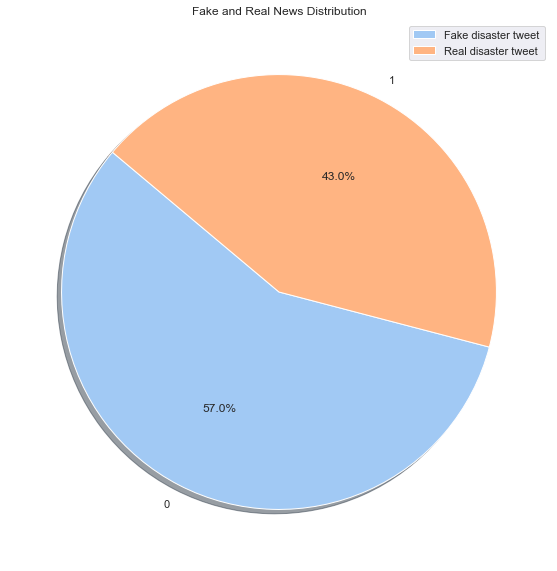

In [14]:
## Pie chart of the number of fake and real news using the target column
colors = sns.color_palette('pastel')[0:2]
sizes = train_data.target.value_counts()

plt.figure(figsize=(15,10))
sizes.plot.pie(autopct='%1.1f%%', colors=colors, shadow=True, startangle=140)
plt.title('Fake and Real News Distribution')
plt.ylabel('')
plt.legend(["Fake disaster tweet", "Real disaster tweet "], loc="best")
plt.savefig('Results/Fake_News_Prediction_Pie_Chart.png', facecolor='w', edgecolor='w')
plt.show()


Hence we can observe that the dataset is skewed towards the Fake News. 57% of the data is Fake News.

## Exploring the location of the Tweets


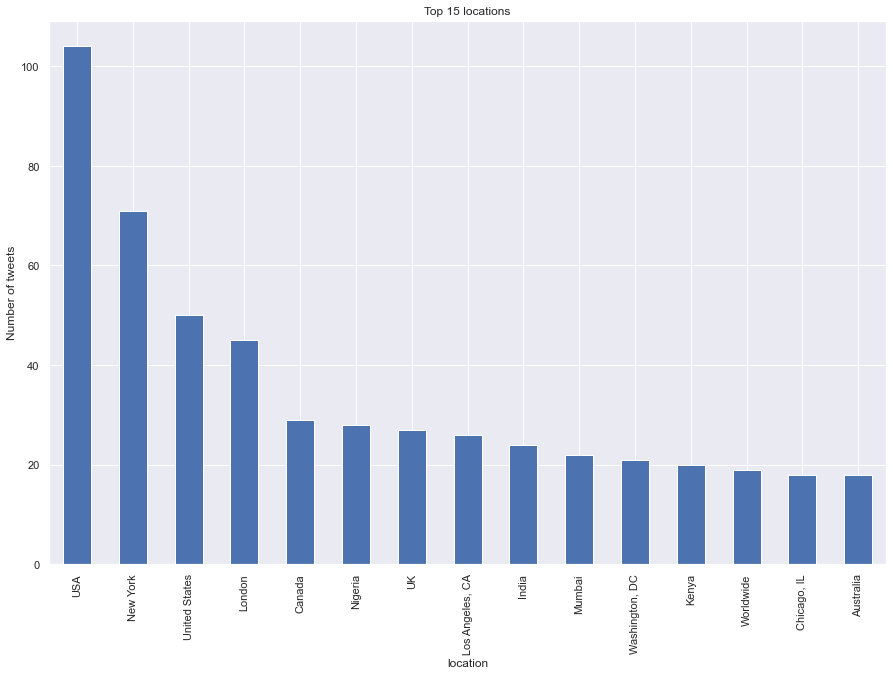

In [8]:
## Bar plot of number of tweets from a given location using seaborn
# Change the background color of the plot
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
train_data.groupby('location')['location'].count().sort_values(ascending=False).head(15).plot(kind='bar',figsize=(15,10)) 
plt.title('Top 15 locations')
plt.ylabel('Number of tweets')
plt.savefig('Results/Location_Bar_Plot.png', facecolor='w', edgecolor='w')
# plt.grid(False)
plt.show()



Hence we can observe that the location of the tweets are mostly in the United States.

## Visualizing the Locations of the Tweets on a Map

In [10]:
df = train_data['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="myapplication")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
Everywhere
New York, NY
California, USA
Florida


### Distribution of the Real and Fake Tweets based on the location

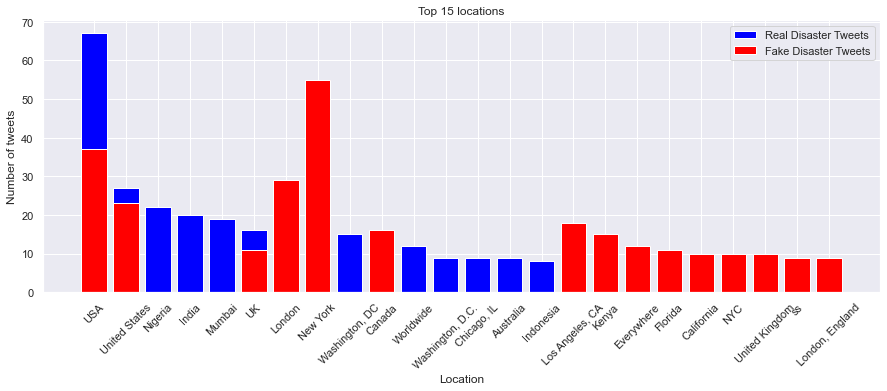

In [16]:
## Bar plot for real and fake news based on the location using Seaborn 
train_1 = train_data[train_data.target == 1]
train_0 = train_data[train_data.target == 0]

cnt_1 = train_1['location'].value_counts()
cnt_0 = train_0['location'].value_counts()

cnt_1 = cnt_1[:15]
cnt_0 = cnt_0[:15]

# Plotting the bar plot
plt.figure(figsize=(15,5))
plt.bar(cnt_1.index, cnt_1.values, color='blue', label='Real Disaster Tweets')
plt.bar(cnt_0.index, cnt_0.values, color='red', label='Fake Disaster Tweets')
plt.title('Top 15 locations')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.ylabel('Number of tweets')
plt.legend()
plt.savefig('Results/Location_Distribution_Bar_Plot.png', facecolor='w', edgecolor='w')
plt.show()

## Adding more features to the dataset based on the properties of the Tweets

### Total Word Count

In [17]:
# Create a column for the number of words in each tweet
train_data['num_words'] = train_data['text'].apply(lambda x: len(x.split()))

In [18]:
train_data.head()

,id,keyword,location,text,target,num_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16


#### Distribution of Word Count for Real and Fake Tweets

C:\Users\Vinit\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Vinit\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



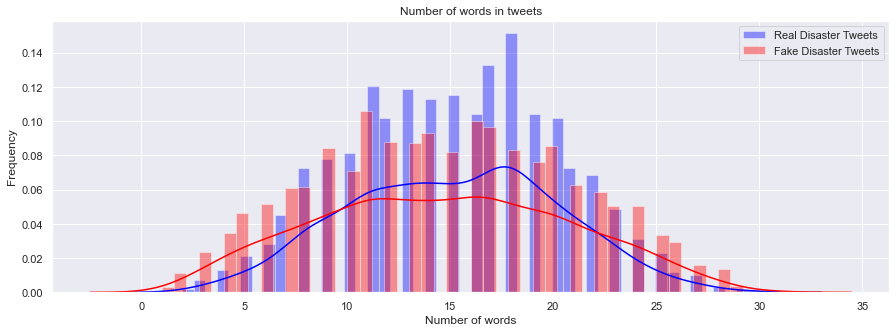

In [19]:
# Plotting the number of words in real and fake tweets using Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
sns.distplot(train_data[train_data.target == 1]['num_words'], bins=50, color='blue', label='Real Disaster Tweets')
sns.distplot(train_data[train_data.target == 0]['num_words'], bins=50, color='red', label='Fake Disaster Tweets')
plt.title('Number of words in tweets')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Results/Number_of_words_in_Tweets_Distribution_Bar_Plot.png', facecolor='w', edgecolor='w')
plt.show()

From the above plot we can observe that the distribution of fake disasters is skewed towards the left side of the plot. This is because the word count of the fake news is less than the word count of the real news.

### Total Character Count

In [20]:
# Create a column for the number of characters in each tweet
train_data['num_chars'] = train_data['text'].apply(lambda x: len(x))

In [21]:
train_data.head()

,id,keyword,location,text,target,num_words,num_chars
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88


#### Distribution of Character Count for Real and Fake Tweets

C:\Users\Vinit\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Vinit\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



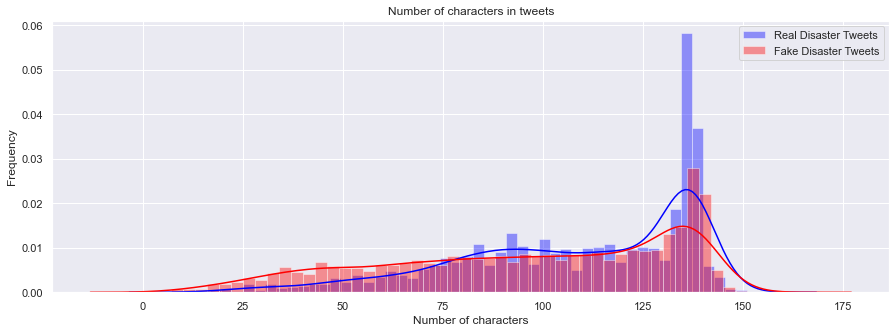

In [22]:
#### Distribution of Character Count for Real and Fake Tweets
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
sns.distplot(train_data[train_data.target == 1]['num_chars'], bins=50, color='blue', label='Real Disaster Tweets')
sns.distplot(train_data[train_data.target == 0]['num_chars'], bins=50, color='red', label='Fake Disaster Tweets')
plt.title('Number of characters in tweets')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Results/Number_of_characters_in_Tweets_Distribution_Bar_Plot.png', facecolor='w', edgecolor='w')
plt.show()

From the above plot we can see that the distribution of both real and fake tweets is similar. Hence, we can conclude that the character count of the tweets is similar.